In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Sucessor do Mask-RCNN
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

In [5]:
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
#outputs = predictor(im)

[01/24 18:06:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


# Custom dataset

# Register the dataset

https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html

In [6]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode


def get_custom_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_project_test.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []

        for anno in annos:
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,  # TODO: classes to corn stage
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("corn_" + d, lambda d=d: get_custom_dicts("corn/" + d))
    MetadataCatalog.get("corn_" + d).set(thing_classes=["E0","E1"])
corn_metadata = MetadataCatalog.get("corn_train")

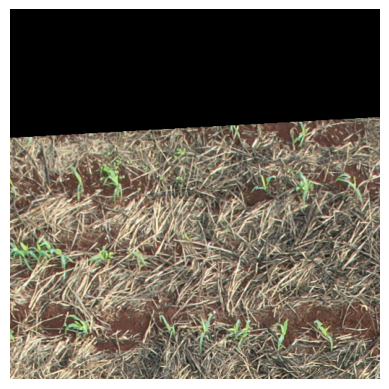

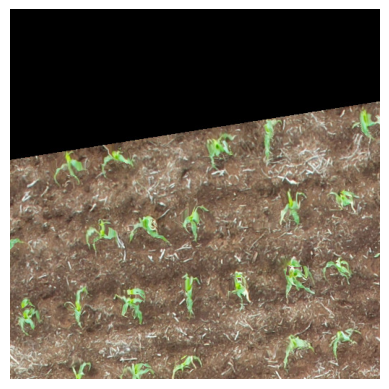

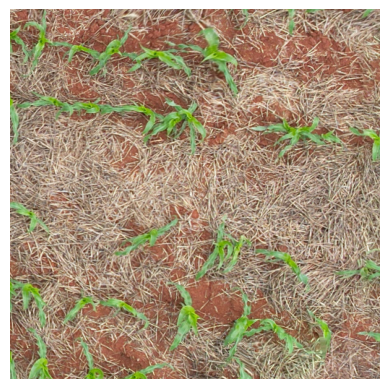

In [11]:
dataset_dicts = get_custom_dicts("corn/train")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

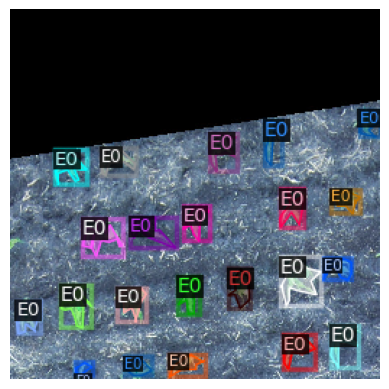

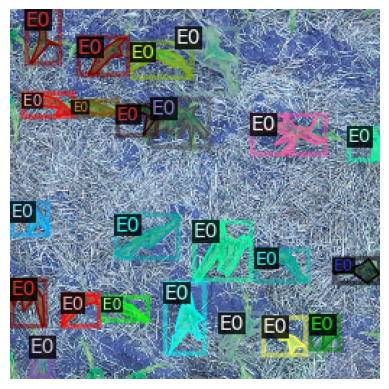

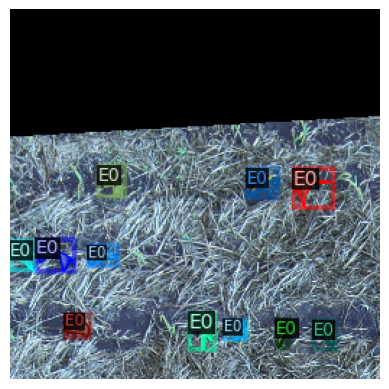

In [5]:
dataset_dicts = get_custom_dicts("corn/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=corn_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    result = out.get_image()[:, :, ::-1]
    plt.imshow(result)
    plt.axis('off')
    plt.show()

# Fine-tune 

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_custom_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result = out.get_image()[:, :, ::-1]
    plt.imshow(result)
    plt.axis('off')
    plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`


### **1. Descrição das Métricas Retornadas**

| Métrica   | Significado                                                                 |
|-----------|-----------------------------------------------------------------------------|
| **AP**    | Precisão média em todos os limiares de IoU - Intersecção sobre União (de 0.50 a 0.95 com incremento de 0.05). Essa é a métrica principal usada no COCO. |
| **AP50**  | Precisão média considerando um IoU fixo de 0.50. É menos rigorosa (detecção grosseira). |
| **AP75**  | Precisão média considerando um IoU fixo de 0.75. É mais rigorosa (detecção precisa). |
| **APs**   | Precisão média para objetos pequenos (área < 32² pixels).                   |
| **APm**   | Precisão média para objetos médios (32² ≤ área < 96² pixels).               |
| **APl**   | Precisão média para objetos grandes (área ≥ 96² pixels).                   |

---

### **2. Interpretação das Métricas no Resultado**

|   **AP**   |  **AP50** |  **AP75** |  **APs**  |  **APm**   |  **APl**   |
|:----------:|:---------:|:---------:|:---------:|:----------:|:----------:|
| **75.417** | **80.878**| **80.878**| **0.000** | **50.552** | **96.493** |

- **AP (75.417)**: Precisão média geral do modelo. Um valor acima de 75 indica um desempenho sólido.
- **AP50 (80.878)**: Desempenho do modelo com um limiar de IoU menos rigoroso. O modelo detecta bem objetos de forma "grosseira".
- **AP75 (80.878)**: Similar ao AP50, indicando que o modelo também é bom em detecção com limites mais rigorosos.
- **APs (0.000)**: O modelo falhou completamente para objetos pequenos. Isso pode ocorrer por falta de exemplos ou dificuldade do modelo em detectar objetos pequenos.
- **APm (50.552)**: Precisão média para objetos médios foi razoável.
- **APl (96.493)**: Desempenho excelente para objetos grandes.

---

### **3. Como Melhorar o Desempenho com Base Nessas Métricas**

- **Baixo APs (Objetos Pequenos)**:
  - Verifique se há exemplos suficientes de objetos pequenos no dataset.
  - Aumente a resolução das imagens para destacar objetos pequenos.
  - Use augmentações, como zoom, para melhorar o treinamento nesses casos.

- **AP Geral Baixo (< 75)**:
  - Treine por mais iterações ou ajuste a taxa de aprendizado.
  - Verifique a qualidade e consistência das anotações no dataset.
  - Experimente um backbone mais poderoso, como **ResNet-101** ou **Swin Transformer**.


Outros tipos de modelos

In [23]:

def cv2_imshow(out):
    result = out.get_image()[:, :, ::-1]
    plt.imshow(result)
    plt.axis('off')
    plt.show()

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out)

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out)

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out)